In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.optim import Adam
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
# Создание и нормализация обучающей, тестовой и выборки валидации

batch_size = 128

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((128, 128)),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_path = "Datasets/Vehicle/train"
train_ds = datasets.ImageFolder(root=train_path, transform=transform)
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)

test_path = "Datasets/Vehicle/test"
test_ds = datasets.ImageFolder(root=test_path, transform=transform)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, pin_memory=True)

validation_path = "Datasets/Vehicle/val"
validation_ds = datasets.ImageFolder(root=validation_path, transform=transform)
validation_dataloader = DataLoader(validation_ds, batch_size=batch_size, shuffle=True, pin_memory=True)

In [34]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Feature batch shape: torch.Size([128, 3, 128, 128])
Labels batch shape: torch.Size([128])


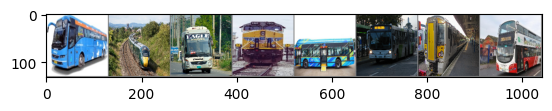

Buses	 Trains	 Buses	 Trains	 Buses	 Buses	 Trains	 Buses	


In [35]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
images = []
for i in range(8):
    images.append(train_features[i])
imshow(torchvision.utils.make_grid(images)) # show images
print(' '.join(f'{train_ds.classes[train_labels[j]]}\t' for j in range(8))) # print labels


In [43]:
class CNN(nn.Module):
    def __init__(self, channel, num_classes):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(channel, 10, kernel_size=3),
                                    nn.BatchNorm2d(10),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(nn.Conv2d(10, 20, kernel_size=3),
                                    nn.BatchNorm2d(20),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(nn.Conv2d(20, 30, kernel_size=3),
                                    nn.BatchNorm2d(30),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(nn.Conv2d(30, 40, kernel_size=3),
                                    nn.BatchNorm2d(40),
                                    nn.ReLU())


        self.fc1 = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(40*12*12, 512),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(512, 128),
            nn.ReLU())
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(-1, 40*12*12)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return nn.functional.softmax(x, dim=1)

In [45]:
model = CNN(3, len(test_ds.classes))
model.to(device)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(30, 40, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [46]:
for i, l in test_dataloader:
    print(model(i.to(device)).shape)
    break

torch.Size([128, 8])


In [47]:
def train(model, train_dataloader, optimizer, loss_func):
    losses = []
    model.train()
    print('Train')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for data, labels in tqdm(train_dataloader):
        counter += 1
        data = data.to(device)
        labels = labels.to(device)

        outputs = model(data)
        # calculate the loss
        loss = loss_func(outputs, labels)
        train_running_loss += loss.item()
        losses.append(loss.item())
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(train_dataloader.dataset))
    return epoch_loss, epoch_acc, losses

In [48]:
def validate(model, validation_dataloader, loss_func):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for data, labels in tqdm(validation_dataloader):
            counter += 1
            data = data.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(data)
            # calculate the loss
            loss = loss_func(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(validation_dataloader.dataset))
    return epoch_loss, epoch_acc

In [50]:
optimizer = Adam(params=model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
num_epochs = 50

In [51]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
all_t_losses = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} of {num_epochs}")
    train_epoch_loss, train_epoch_acc, all_t_epoch_losses = train(model, train_dataloader, 
                                              optimizer, loss_func)
    valid_epoch_loss, valid_epoch_acc = validate(model, validation_dataloader,  
                                                 loss_func)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    all_t_losses.append(all_t_epoch_losses)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)

Epoch 1 of 50
Train


 32%|███▏      | 6/19 [00:13<00:29,  2.27s/it]c:\Users\RIEKI\Documents\VSU\Otirba\PythonTasks\ML_DNN\.venv\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 19/19 [00:41<00:00,  2.20s/it]


Validation


100%|██████████| 13/13 [00:33<00:00,  2.60s/it]


Training loss: 1.994, training acc: 25.855
Validation loss: 2.086, validation acc: 15.125
--------------------------------------------------
Epoch 2 of 50
Train


100%|██████████| 19/19 [00:43<00:00,  2.27s/it]


Validation


100%|██████████| 13/13 [00:33<00:00,  2.59s/it]


Training loss: 1.858, training acc: 41.910
Validation loss: 1.897, validation acc: 36.875
--------------------------------------------------
Epoch 3 of 50
Train


100%|██████████| 19/19 [00:42<00:00,  2.25s/it]


Validation


100%|██████████| 13/13 [00:34<00:00,  2.66s/it]


Training loss: 1.783, training acc: 48.791
Validation loss: 1.831, validation acc: 42.250
--------------------------------------------------
Epoch 4 of 50
Train


100%|██████████| 19/19 [00:42<00:00,  2.26s/it]


Validation


100%|██████████| 13/13 [00:33<00:00,  2.61s/it]


Training loss: 1.720, training acc: 55.463
Validation loss: 1.805, validation acc: 46.688
--------------------------------------------------
Epoch 5 of 50
Train


100%|██████████| 19/19 [00:42<00:00,  2.22s/it]


Validation


100%|██████████| 13/13 [00:33<00:00,  2.57s/it]


Training loss: 1.627, training acc: 65.304
Validation loss: 1.707, validation acc: 55.937
--------------------------------------------------
Epoch 6 of 50
Train


100%|██████████| 19/19 [00:43<00:00,  2.30s/it]


Validation


100%|██████████| 13/13 [00:36<00:00,  2.79s/it]


Training loss: 1.595, training acc: 68.390
Validation loss: 1.669, validation acc: 61.187
--------------------------------------------------
Epoch 7 of 50
Train


100%|██████████| 19/19 [00:42<00:00,  2.23s/it]


Validation


100%|██████████| 13/13 [00:33<00:00,  2.60s/it]


Training loss: 1.555, training acc: 72.310
Validation loss: 1.632, validation acc: 63.688
--------------------------------------------------
Epoch 8 of 50
Train


100%|██████████| 19/19 [00:46<00:00,  2.42s/it]


Validation


100%|██████████| 13/13 [00:37<00:00,  2.87s/it]


Training loss: 1.531, training acc: 74.854
Validation loss: 1.631, validation acc: 64.312
--------------------------------------------------
Epoch 9 of 50
Train


100%|██████████| 19/19 [00:48<00:00,  2.53s/it]


Validation


100%|██████████| 13/13 [00:39<00:00,  3.05s/it]


Training loss: 1.500, training acc: 77.440
Validation loss: 1.613, validation acc: 65.625
--------------------------------------------------
Epoch 10 of 50
Train


100%|██████████| 19/19 [00:49<00:00,  2.62s/it]


Validation


100%|██████████| 13/13 [00:39<00:00,  3.08s/it]


Training loss: 1.480, training acc: 79.233
Validation loss: 1.604, validation acc: 66.812
--------------------------------------------------
Epoch 11 of 50
Train


100%|██████████| 19/19 [00:50<00:00,  2.66s/it]


Validation


100%|██████████| 13/13 [00:33<00:00,  2.61s/it]


Training loss: 1.469, training acc: 80.859
Validation loss: 1.620, validation acc: 65.062
--------------------------------------------------
Epoch 12 of 50
Train


100%|██████████| 19/19 [00:43<00:00,  2.27s/it]


Validation


100%|██████████| 13/13 [00:34<00:00,  2.63s/it]


Training loss: 1.459, training acc: 81.902
Validation loss: 1.637, validation acc: 63.250
--------------------------------------------------
Epoch 13 of 50
Train


100%|██████████| 19/19 [00:43<00:00,  2.27s/it]


Validation


100%|██████████| 13/13 [00:33<00:00,  2.61s/it]


Training loss: 1.450, training acc: 82.652
Validation loss: 1.597, validation acc: 67.875
--------------------------------------------------
Epoch 14 of 50
Train


100%|██████████| 19/19 [00:43<00:00,  2.31s/it]


Validation


100%|██████████| 13/13 [00:33<00:00,  2.59s/it]


Training loss: 1.435, training acc: 84.279
Validation loss: 1.630, validation acc: 64.250
--------------------------------------------------
Epoch 15 of 50
Train


100%|██████████| 19/19 [00:42<00:00,  2.25s/it]


Validation


100%|██████████| 13/13 [00:35<00:00,  2.70s/it]


Training loss: 1.440, training acc: 83.611
Validation loss: 1.621, validation acc: 64.312
--------------------------------------------------
Epoch 16 of 50
Train


100%|██████████| 19/19 [00:43<00:00,  2.31s/it]


Validation


100%|██████████| 13/13 [00:32<00:00,  2.53s/it]


Training loss: 1.428, training acc: 85.196
Validation loss: 1.587, validation acc: 69.125
--------------------------------------------------
Epoch 17 of 50
Train


100%|██████████| 19/19 [00:41<00:00,  2.18s/it]


Validation


100%|██████████| 13/13 [00:32<00:00,  2.48s/it]


Training loss: 1.418, training acc: 85.905
Validation loss: 1.619, validation acc: 65.062
--------------------------------------------------
Epoch 18 of 50
Train


100%|██████████| 19/19 [00:42<00:00,  2.22s/it]


Validation


100%|██████████| 13/13 [00:32<00:00,  2.51s/it]


Training loss: 1.403, training acc: 87.239
Validation loss: 1.553, validation acc: 72.188
--------------------------------------------------
Epoch 19 of 50
Train


100%|██████████| 19/19 [00:41<00:00,  2.20s/it]


Validation


100%|██████████| 13/13 [00:33<00:00,  2.56s/it]


Training loss: 1.391, training acc: 88.699
Validation loss: 1.596, validation acc: 67.938
--------------------------------------------------
Epoch 20 of 50
Train


100%|██████████| 19/19 [00:41<00:00,  2.19s/it]


Validation


100%|██████████| 13/13 [00:33<00:00,  2.56s/it]


Training loss: 1.391, training acc: 88.824
Validation loss: 1.579, validation acc: 69.938
--------------------------------------------------
Epoch 21 of 50
Train


100%|██████████| 19/19 [00:42<00:00,  2.24s/it]


Validation


100%|██████████| 13/13 [00:33<00:00,  2.54s/it]


Training loss: 1.396, training acc: 87.948
Validation loss: 1.576, validation acc: 69.812
--------------------------------------------------
Epoch 22 of 50
Train


100%|██████████| 19/19 [00:42<00:00,  2.22s/it]


Validation


100%|██████████| 13/13 [00:32<00:00,  2.53s/it]


Training loss: 1.382, training acc: 89.616
Validation loss: 1.554, validation acc: 71.688
--------------------------------------------------
Epoch 23 of 50
Train


100%|██████████| 19/19 [00:42<00:00,  2.22s/it]


Validation


100%|██████████| 13/13 [00:32<00:00,  2.51s/it]


Training loss: 1.380, training acc: 89.700
Validation loss: 1.597, validation acc: 67.188
--------------------------------------------------
Epoch 24 of 50
Train


100%|██████████| 19/19 [00:41<00:00,  2.20s/it]


Validation


100%|██████████| 13/13 [00:32<00:00,  2.53s/it]


Training loss: 1.372, training acc: 90.409
Validation loss: 1.552, validation acc: 71.562
--------------------------------------------------
Epoch 25 of 50
Train


100%|██████████| 19/19 [00:41<00:00,  2.17s/it]


Validation


100%|██████████| 13/13 [00:33<00:00,  2.56s/it]


Training loss: 1.368, training acc: 90.909
Validation loss: 1.558, validation acc: 71.000
--------------------------------------------------
Epoch 26 of 50
Train


100%|██████████| 19/19 [00:43<00:00,  2.30s/it]


Validation


100%|██████████| 13/13 [00:35<00:00,  2.73s/it]


Training loss: 1.369, training acc: 90.701
Validation loss: 1.641, validation acc: 63.000
--------------------------------------------------
Epoch 27 of 50
Train


100%|██████████| 19/19 [00:45<00:00,  2.37s/it]


Validation


100%|██████████| 13/13 [00:35<00:00,  2.73s/it]


Training loss: 1.359, training acc: 91.910
Validation loss: 1.560, validation acc: 71.562
--------------------------------------------------
Epoch 28 of 50
Train


100%|██████████| 19/19 [00:44<00:00,  2.35s/it]


Validation


100%|██████████| 13/13 [00:33<00:00,  2.60s/it]


Training loss: 1.351, training acc: 92.410
Validation loss: 1.593, validation acc: 68.000
--------------------------------------------------
Epoch 29 of 50
Train


100%|██████████| 19/19 [00:42<00:00,  2.26s/it]


Validation


100%|██████████| 13/13 [00:33<00:00,  2.59s/it]


Training loss: 1.343, training acc: 93.161
Validation loss: 1.558, validation acc: 71.500
--------------------------------------------------
Epoch 30 of 50
Train


100%|██████████| 19/19 [00:42<00:00,  2.25s/it]


Validation


100%|██████████| 13/13 [00:33<00:00,  2.61s/it]


Training loss: 1.340, training acc: 93.620
Validation loss: 1.561, validation acc: 71.438
--------------------------------------------------
Epoch 31 of 50
Train


100%|██████████| 19/19 [00:43<00:00,  2.29s/it]


Validation


100%|██████████| 13/13 [00:33<00:00,  2.60s/it]


Training loss: 1.333, training acc: 94.412
Validation loss: 1.540, validation acc: 73.625
--------------------------------------------------
Epoch 32 of 50
Train


100%|██████████| 19/19 [00:42<00:00,  2.25s/it]


Validation


100%|██████████| 13/13 [00:34<00:00,  2.62s/it]


Training loss: 1.333, training acc: 94.204
Validation loss: 1.558, validation acc: 71.125
--------------------------------------------------
Epoch 33 of 50
Train


100%|██████████| 19/19 [00:42<00:00,  2.26s/it]


Validation


100%|██████████| 13/13 [00:33<00:00,  2.58s/it]


Training loss: 1.334, training acc: 94.245
Validation loss: 1.582, validation acc: 68.875
--------------------------------------------------
Epoch 34 of 50
Train


100%|██████████| 19/19 [00:42<00:00,  2.24s/it]


Validation


100%|██████████| 13/13 [00:33<00:00,  2.59s/it]


Training loss: 1.332, training acc: 94.329
Validation loss: 1.545, validation acc: 72.812
--------------------------------------------------
Epoch 35 of 50
Train


100%|██████████| 19/19 [00:43<00:00,  2.29s/it]


Validation


100%|██████████| 13/13 [00:34<00:00,  2.63s/it]


Training loss: 1.323, training acc: 95.455
Validation loss: 1.558, validation acc: 71.125
--------------------------------------------------
Epoch 36 of 50
Train


100%|██████████| 19/19 [00:42<00:00,  2.24s/it]


Validation


100%|██████████| 13/13 [00:33<00:00,  2.58s/it]


Training loss: 1.325, training acc: 95.121
Validation loss: 1.576, validation acc: 69.750
--------------------------------------------------
Epoch 37 of 50
Train


100%|██████████| 19/19 [00:42<00:00,  2.25s/it]


Validation


100%|██████████| 13/13 [00:33<00:00,  2.59s/it]


Training loss: 1.329, training acc: 94.787
Validation loss: 1.569, validation acc: 70.438
--------------------------------------------------
Epoch 38 of 50
Train


100%|██████████| 19/19 [00:42<00:00,  2.25s/it]


Validation


100%|██████████| 13/13 [00:33<00:00,  2.59s/it]


Training loss: 1.331, training acc: 94.412
Validation loss: 1.555, validation acc: 71.688
--------------------------------------------------
Epoch 39 of 50
Train


100%|██████████| 19/19 [00:42<00:00,  2.25s/it]


Validation


100%|██████████| 13/13 [00:33<00:00,  2.61s/it]


Training loss: 1.324, training acc: 95.163
Validation loss: 1.553, validation acc: 71.500
--------------------------------------------------
Epoch 40 of 50
Train


100%|██████████| 19/19 [00:42<00:00,  2.25s/it]


Validation


100%|██████████| 13/13 [00:34<00:00,  2.62s/it]


Training loss: 1.336, training acc: 93.953
Validation loss: 1.559, validation acc: 71.438
--------------------------------------------------
Epoch 41 of 50
Train


100%|██████████| 19/19 [00:42<00:00,  2.25s/it]


Validation


100%|██████████| 13/13 [00:34<00:00,  2.65s/it]


Training loss: 1.332, training acc: 94.454
Validation loss: 1.540, validation acc: 73.062
--------------------------------------------------
Epoch 42 of 50
Train


100%|██████████| 19/19 [00:43<00:00,  2.30s/it]


Validation


100%|██████████| 13/13 [00:33<00:00,  2.57s/it]


Training loss: 1.322, training acc: 95.371
Validation loss: 1.528, validation acc: 74.500
--------------------------------------------------
Epoch 43 of 50
Train


100%|██████████| 19/19 [00:42<00:00,  2.26s/it]


Validation


100%|██████████| 13/13 [00:34<00:00,  2.62s/it]


Training loss: 1.322, training acc: 95.204
Validation loss: 1.539, validation acc: 73.062
--------------------------------------------------
Epoch 44 of 50
Train


100%|██████████| 19/19 [00:42<00:00,  2.25s/it]


Validation


100%|██████████| 13/13 [00:33<00:00,  2.56s/it]


Training loss: 1.330, training acc: 94.662
Validation loss: 1.559, validation acc: 71.625
--------------------------------------------------
Epoch 45 of 50
Train


100%|██████████| 19/19 [00:42<00:00,  2.26s/it]


Validation


100%|██████████| 13/13 [00:34<00:00,  2.62s/it]


Training loss: 1.328, training acc: 94.829
Validation loss: 1.550, validation acc: 71.812
--------------------------------------------------
Epoch 46 of 50
Train


100%|██████████| 19/19 [00:43<00:00,  2.27s/it]


Validation


100%|██████████| 13/13 [00:33<00:00,  2.59s/it]


Training loss: 1.323, training acc: 95.371
Validation loss: 1.554, validation acc: 71.938
--------------------------------------------------
Epoch 47 of 50
Train


100%|██████████| 19/19 [00:43<00:00,  2.29s/it]


Validation


100%|██████████| 13/13 [00:34<00:00,  2.63s/it]


Training loss: 1.319, training acc: 95.788
Validation loss: 1.530, validation acc: 74.812
--------------------------------------------------
Epoch 48 of 50
Train


100%|██████████| 19/19 [00:43<00:00,  2.27s/it]


Validation


100%|██████████| 13/13 [00:33<00:00,  2.57s/it]


Training loss: 1.319, training acc: 95.538
Validation loss: 1.538, validation acc: 73.188
--------------------------------------------------
Epoch 49 of 50
Train


100%|██████████| 19/19 [00:43<00:00,  2.28s/it]


Validation


100%|██████████| 13/13 [00:34<00:00,  2.62s/it]


Training loss: 1.320, training acc: 95.663
Validation loss: 1.529, validation acc: 74.250
--------------------------------------------------
Epoch 50 of 50
Train


100%|██████████| 19/19 [00:43<00:00,  2.28s/it]


Validation


100%|██████████| 13/13 [00:33<00:00,  2.60s/it]

Training loss: 1.318, training acc: 95.746
Validation loss: 1.559, validation acc: 71.125
--------------------------------------------------


In [52]:
#save the trained model weights
torch.save({
                'epoch': num_epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_func,
                }, 'model.pth')

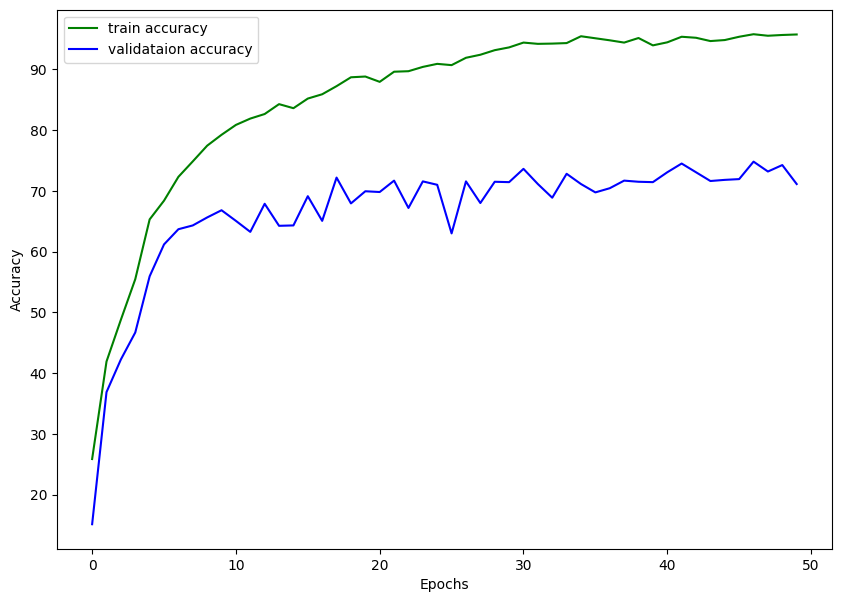

In [53]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_acc, color='green', linestyle='-', 
    label='train accuracy'
)
plt.plot(
    valid_acc, color='blue', linestyle='-', 
    label='validataion accuracy'
)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

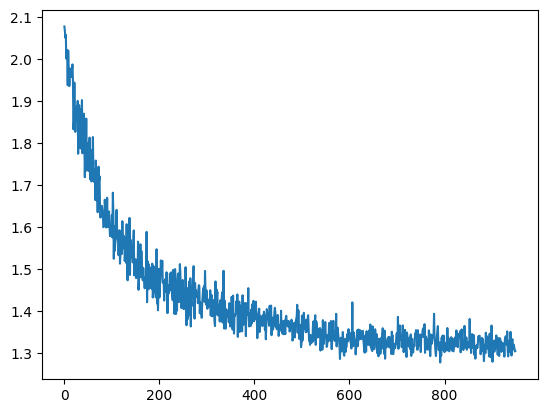

In [54]:
losses = np.array(all_t_losses)
losses =  losses.reshape(len(all_t_losses) * len(all_t_losses[0]))
plt.plot(losses)

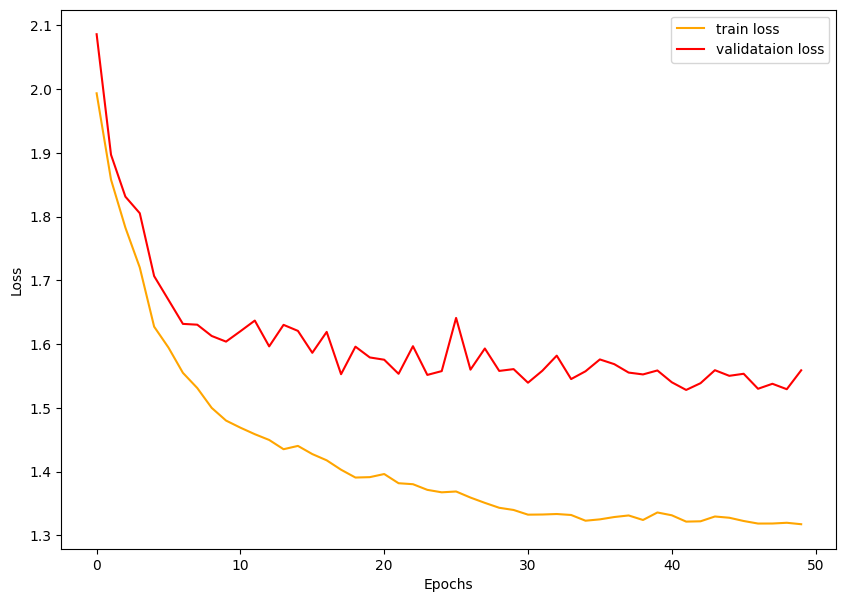

In [55]:
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_loss, color='orange', linestyle='-', 
    label='train loss')
plt.plot(
    valid_loss, color='red', linestyle='-', 
    label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

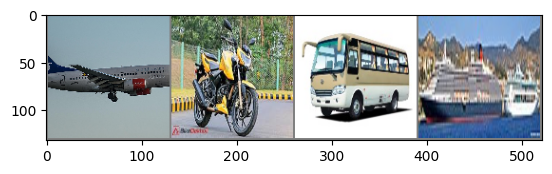

Real value:
Airplanes	 Bikes	 Buses	 Ships	
Predicted value:
Airplanes	 Bikes	 Buses	 Ships	


In [57]:
test_fetures, test_labels = next(iter(test_dataloader))
images = []
for i in range(4):
    images.append(test_fetures[i])
imshow(torchvision.utils.make_grid(images)) # show images
print("Real value:")
print(' '.join(f'{train_ds.classes[test_labels[j]]}\t' for j in range(4))) # print labels
print("Predicted value:")
print(' '.join(f'{train_ds.classes[model(test_fetures[j].view(1, 3, 128, 128).to(device)).argmax()]}\t' for j in range(4)))

In [58]:
real_labels = []
predicted_labels = []
for data, labels in test_dataloader:
    data = data.to(device)
    output = model(data).argmax(dim=1).cpu().detach().numpy()
    for i in range(len(output)):
        predicted_labels.append(output[i])
        real_labels.append(labels[i].detach().item())

In [59]:
from sklearn.metrics import classification_report

print(classification_report(predicted_labels, real_labels, target_names=test_ds.classes))

              precision    recall  f1-score   support

   Airplanes       0.89      0.61      0.72       145
       Bikes       0.88      0.89      0.88        98
       Buses       0.64      0.29      0.40        48
        Cars       0.80      0.79      0.79       100
 Helicopters       0.68      0.61      0.65        83
       Ships       0.73      0.95      0.82        76
      Trains       0.62      0.68      0.65        82
      Trucks       0.43      0.95      0.59        39

    accuracy                           0.72       671
   macro avg       0.71      0.72      0.69       671
weighted avg       0.75      0.72      0.72       671

